# Transformer model to analyze Lund data

* The model based on 	arXiv:1706.03762 [cs.CL]
* Data to the model has the form of (Number of events, jet contents, 5)
* The model has five self attention heads and the transformer layer is repeated for 3 times.

In [1]:
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm 
from keras.datasets import mnist, fashion_mnist,cifar10
from tensorflow.keras.utils import plot_model
import sklearn
from keras import backend as K # The backend is important while we are dealing with keras layers and the basic low level operation cannot be handeled by numpy
from keras.losses import mse, binary_crossentropy,CategoricalCrossentropy
from tqdm import tqdm  
import random    
# Import all the required Libraries
from sklearn.metrics import  roc_curve,auc
import tensorflow
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten,  Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras import regularizers
import os
from scipy.ndimage import gaussian_filter

from keras_nlp.layers import TransformerEncoder 
from matplotlib.colors import LogNorm
import cv2
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

if not tf.test.gpu_device_name():
    warnings.warn('No GPU found.....')
    sys.exit()
else:
    print('Default GPU device :{}'.format(tf.test.gpu_device_name()))
    
    

Using TensorFlow backend
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Default GPU device :/device:GPU:0


In [2]:
## function to flatten list of lists ###
def flatten(t):
    return np.array([item for sublist in t for item in sublist])

In [3]:
### Load the signal and background data ##
Images_SM = np.load('/Users/hammad/work/Lund/data/data_images/data_SM.npz',allow_pickle=True)['arr_0']
Images_sig = np.load('/Users/hammad/work/Lund/data/data_images/data_sig.npz',allow_pickle=True)['arr_0']

print(f'Shape of the signal: {Images_sig.shape},  Shape of the background: {Images_SM.shape}')

Shape of the signal: (103358, 50, 5),  Shape of the background: (102752, 50, 5)


In [4]:
#### Hyper-parameters for transformer #####
num_classes=2
batch_size= 500
epoch = 15
mlp_units = [128,64]
masked = True
######Loss functions and optimizer########
loss_func = keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)
train_accuracy = tf.keras.metrics.CategoricalAccuracy()
test_accuracy = tf.keras.metrics.CategoricalAccuracy()
######################################
## paremters of the first transformer#
######################################
num_heads_1 = 5   ## Nmber of slef attention heads in each transformer layer
num_transformers_1= 2 ## reapt the transformer layer twice
n_constit_1 = 50     # jet constitutents 
n_channels_1 = 5     # ln(kt), ln(1\Delta R)
input_shape_part_1 = (n_constit_1,n_channels_1)
mlp_head_units_1 = [64,n_channels_1]   #dimensions of the last MLP layers

In [5]:
## concate signal and bakground, generate labels and suffle #

x1_data = np.concatenate((Images_sig, Images_SM))
y_data = np.array([1]*len(Images_sig)+[0]*len(Images_SM))

x1_data,y_data = sklearn.utils.shuffle(x1_data,y_data)

In [6]:
### Split the data to train and test samples ####
k_split = int(np.floor(0.8* len(y_data)))

x1_train = x1_data[:k_split]
y_train = y_data[:k_split]

x1_test = x1_data[k_split:]
y_test = y_data[k_split:]

y_train = to_categorical(y_train,2)
y_test = to_categorical(y_test,2)
print(f'''Shape of x1 train: {x1_train.shape},    Shape of y train: {y_train.shape}
Shape of x1 test: {x1_test.shape},    Shape of y test: {y_test.shape}''')

Shape of x1 train: (164888, 50, 5),    Shape of y train: (164888, 2)
Shape of x1 test: (41222, 50, 5),    Shape of y test: (41222, 2)


In [7]:
### the final MLP layers
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x
def masked_fill(tensor, idx,value,n_constit):
    pad_mask = tf.math.equal(tensor[:,:,idx],0)
    mask = tf.where(pad_mask, tf.cast(tf.fill(tf.shape(tensor[...,-1]), value),tf.float32), tensor[:,:,idx])
    mask = tf.repeat(mask[:,tf.newaxis],n_constit,axis=1)
    return mask


### transformer layer with self-attention heads #######
class transformer_encoder_layer_MHSA:
    def __init__(self,heads, dropout,mask,mlp_units):
        self.heads = heads
        self. dropout=dropout
        self.mask = mask
        self.mlp_units = mlp_units

    
    def layer(self,x):     
        MHA = layers.MultiHeadAttention(num_heads=self.heads, key_dim=self.heads, dropout=self.dropout)    
        x1 = layers.LayerNormalization()(x)
        if masked:
            attention_output,weights = MHA(x1, x1, attention_mask = self.mask,return_attention_scores=True)
        else:
            attention_output,weights = MHA(x1, x1, attention_mask = None,return_attention_scores=True)
        x2 = layers.Add()([attention_output, x])
        x3 = layers.LayerNormalization()(x2)
        x3 = mlp(x3, hidden_units=self.mlp_units, dropout_rate=self.dropout)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])
        return encoded_patches

### transformer layer with cross-attention heads #######
def transformer_encoder_layer_MHCA(x,y,heads, dropout,mask,mlp_units):
    MHA = layers.MultiHeadAttention(num_heads=heads, key_dim=heads, dropout=dropout)
    x1 = layers.LayerNormalization()(x)
    y1 = layers.LayerNormalization()(y)
    attention_output,weights = MHA(x1, y1, attention_mask = None,return_attention_scores=True) 
    x2 = layers.Add()([attention_output, x])
    #x3 = layers.LayerNormalization()(attention_output)
    x3 = layers.LayerNormalization()(x2)
    x3 = mlp(x3, hidden_units=mlp_units, dropout_rate=dropout)
    # Skip connection 2.
    encoded_patches = layers.Add()([x3, attention_output])
    return encoded_patches


In [8]:
#### Create the model #########

def create_Part_classifier():
    inputs_1 = layers.Input(shape=input_shape_part_1)    
    if masked:
        attention_mask_1= masked_fill(inputs_1,1,-np.inf,inputs_1.shape[1])
    else:
        attention_mask_1= None
        
     
    transformer_encoder_1 = transformer_encoder_layer_MHSA(num_heads_1,0.1,attention_mask_1,mlp_head_units_1)
    encoded_patches_1 = layers.LayerNormalization()(inputs_1)
     
    for _ in range(num_transformers_1):
        encoded_patches_1 = transformer_encoder_1.layer(encoded_patches_1)
         
    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches_1)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.2)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_units, dropout_rate=0.2)
    logits = layers.Dense(num_classes,activation='softmax')(features)
    model = keras.Model(inputs=inputs_1, outputs=logits)
    return model

In [9]:
model_part = create_Part_classifier()
#model_part.summary()

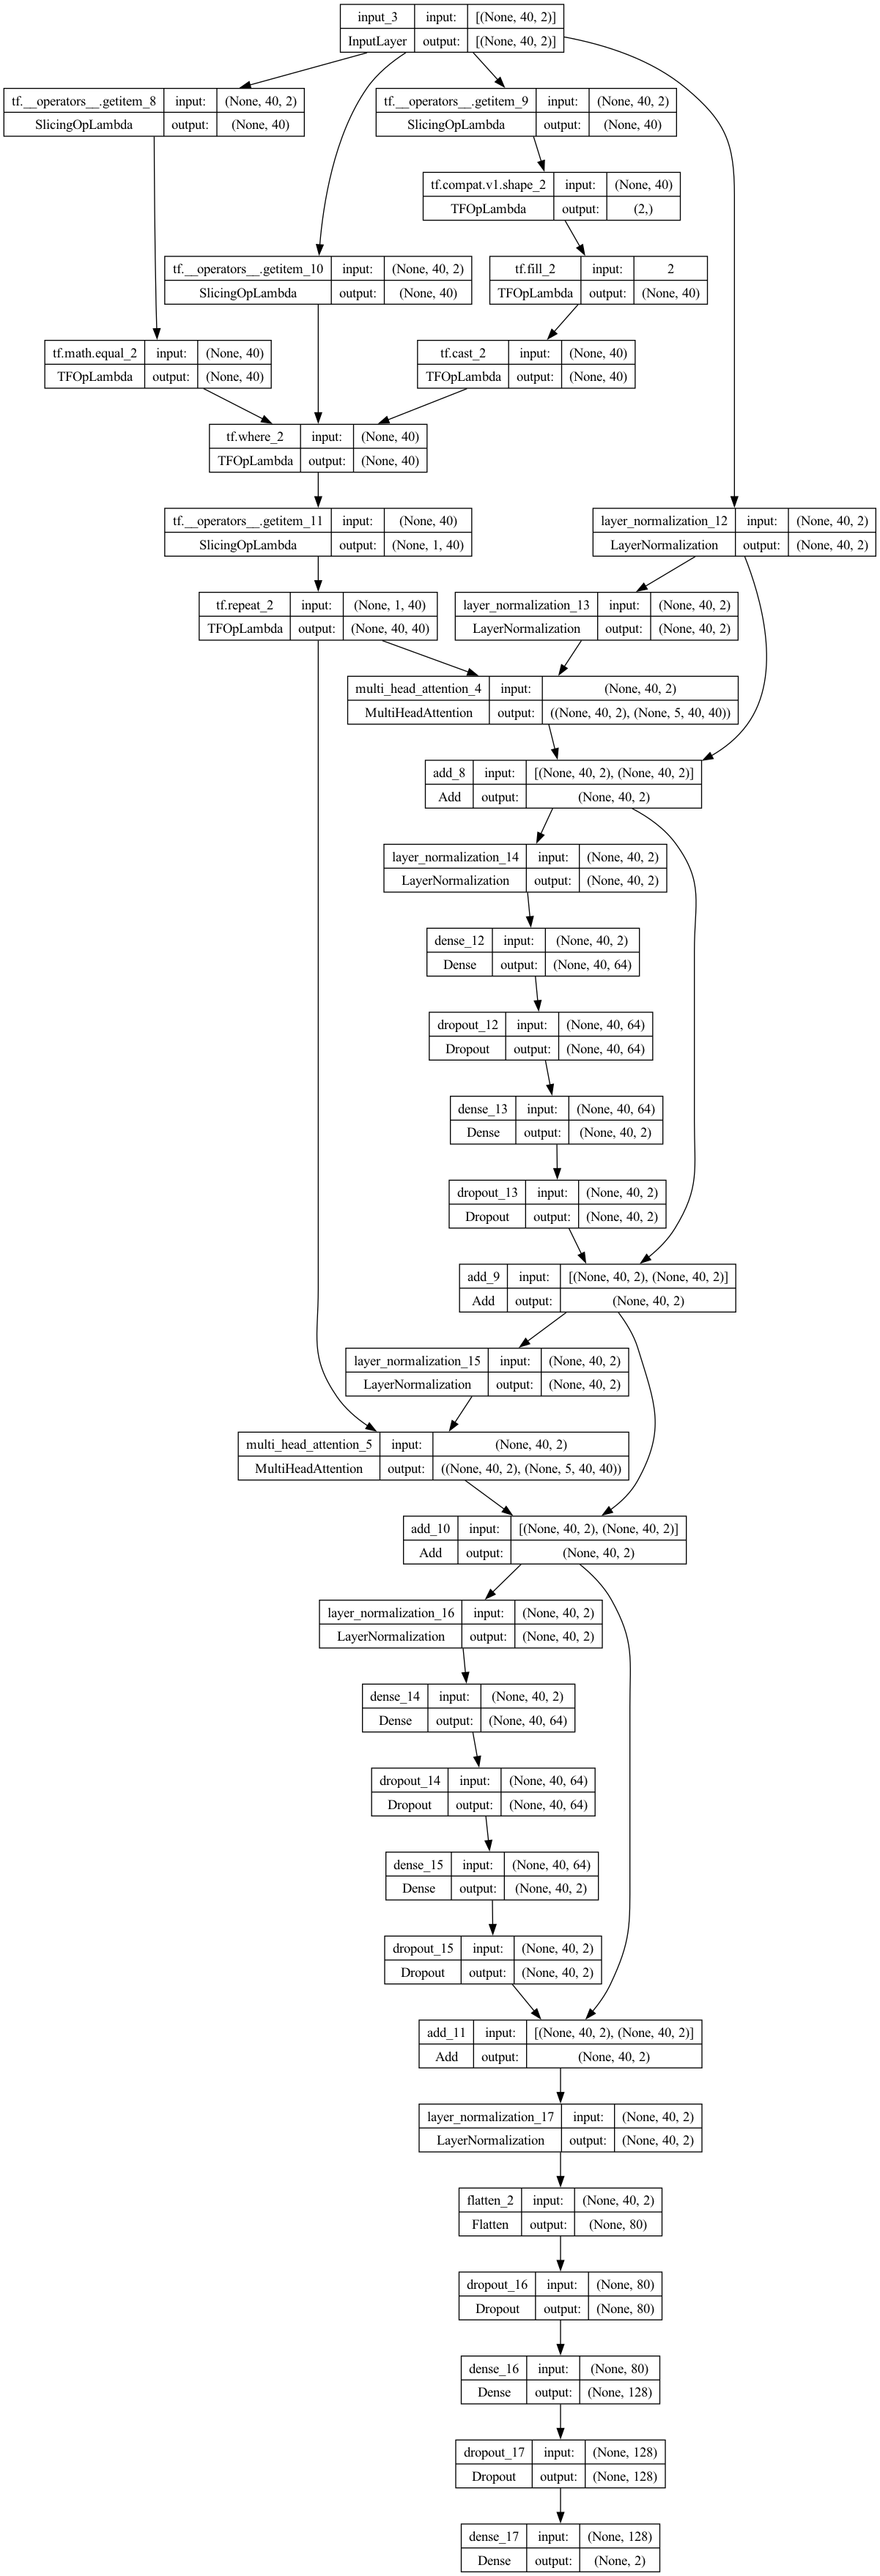

In [27]:
# Plot the model 
tf.keras.utils.plot_model(model_part,show_shapes=True,expand_nested=True)

In [10]:
### Training loop function per training batch 
@tf.function
def train_step(x, y,model):
    with tf.GradientTape() as tape:
        logit = model(x, training=True)
        loss_value = loss_func(y, logit)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_accuracy.update_state(y, logit)
    return loss_value,train_accuracy.result()

### function to test the loss and accuracy per training batch
@tf.function
def test_step(x, y,model):
    val_logit = model(x, training=False)
    test_accuracy.update_state(y, val_logit)
### Function to the test the model accuracy on the model test data    
def test_acc(model,x, y):
    val_logit = model(x, training=False)
    test_accuracy.update_state(y, val_logit)
    return print(f'Test Accuracy:  {test_accuracy.result()*100 :.3f}%')    


def training_loop(model,x_train,y_train,epochs=20,batch_size=512):
    ## Lets create the batches first
    train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(x_train.shape[0]).batch(batch_size) 
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_acc_avg = tf.keras.metrics.Mean()
    for epoch in range(epochs):
    # Iterate over the batches of the dataset.
        loss,acc = [],[]
        for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
            
            loss_value,acc_value = train_step(x_batch_train, y_batch_train,model)
            loss.append(loss_value)
            acc.append(acc_value)
            epoch_loss_avg.update_state(loss) 
            epoch_acc_avg.update_state(acc)  
            if step % 1 == 0:
                sys.stdout.write('\r'+'step %s :  loss = %2.5f  accuracy = %2.5f'%((step + 1),float(loss_value),float(acc_value)))
           
        # Display metrics at the end of each epoch.
        tf.print('|   Epoch {:2d}:  Loss (Avg): {:2.5f}  Accuracy (Avg): {:2.5f}'.format(epoch+1,epoch_loss_avg.result(),epoch_acc_avg.result()))  
        # Reset training metrics at the end of each epoch
        train_accuracy.reset_states()

In [11]:
training_loop(model_part,x1_train,y_train,epochs=epoch,batch_size=batch_size)

step 330 :  loss = 0.37417  accuracy = 0.81170|   Epoch  1:  Loss (Avg): 0.45170  Accuracy (Avg): 0.71371
step 330 :  loss = 0.35419  accuracy = 0.85490|   Epoch  2:  Loss (Avg): 0.39617  Accuracy (Avg): 0.78409
step 330 :  loss = 0.35287  accuracy = 0.85914|   Epoch  3:  Loss (Avg): 0.37430  Accuracy (Avg): 0.80818
step 330 :  loss = 0.29218  accuracy = 0.86191|   Epoch  4:  Loss (Avg): 0.36151  Accuracy (Avg): 0.82108
step 330 :  loss = 0.36666  accuracy = 0.86442|   Epoch  5:  Loss (Avg): 0.35244  Accuracy (Avg): 0.82971
step 330 :  loss = 0.33087  accuracy = 0.86754|   Epoch  6:  Loss (Avg): 0.34568  Accuracy (Avg): 0.83581
step 330 :  loss = 0.34734  accuracy = 0.86817|   Epoch  7:  Loss (Avg): 0.34047  Accuracy (Avg): 0.84049
step 330 :  loss = 0.28854  accuracy = 0.87028|   Epoch  8:  Loss (Avg): 0.33602  Accuracy (Avg): 0.84433
step 330 :  loss = 0.28138  accuracy = 0.87090|   Epoch  9:  Loss (Avg): 0.33233  Accuracy (Avg): 0.84737
step 330 :  loss = 0.34005  accuracy = 0.87270

In [12]:
test_acc(model_part,x1_test,y_test)

Test Accuracy:  88.700%


In [13]:
score=model_part.predict(x1_test);
fpr, tpr, _ = roc_curve(y_test.ravel(),score.ravel());

1289/1289 [==============================] - 21s 15ms/step


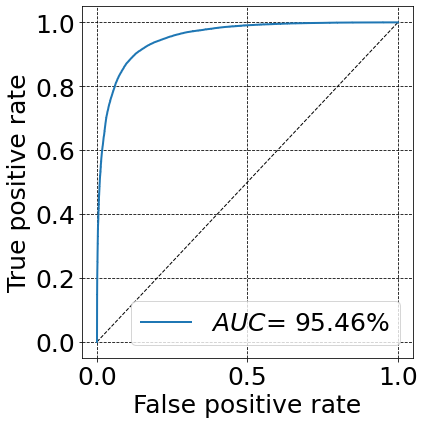

In [14]:
plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1],'k--',linewidth=1);
plt.plot(fpr,tpr,linewidth=2,label=r'$AUC$= {:.2f}%'.format(float(auc(fpr, tpr))*100));
plt.xlabel(r'False positive rate',fontsize=25,c='k');
plt.ylabel(r'True positive rate',fontsize=25,c='k');
plt.grid(linestyle='--',c='k')
plt.legend(loc='best',fontsize=25);
plt.tick_params(axis='both',labelsize=25)
plt.tight_layout()

In [15]:
np.savetxt('fpr_Lund_transformer.txt',fpr);
np.savetxt('tpr_Lund_transformer.txt',tpr);